In [1]:
#importing required libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from itertools import product
import warnings
warnings.filterwarnings("ignore")
from sklearn.impute import SimpleImputer
from scipy import stats
import seaborn as sns
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [2]:
# Loading datasets
unemployment_rate = pd.read_csv('Unemployment Rate.csv')
gdp = pd.read_csv('Gross Domestic Product.csv')
spx500 = pd.read_csv('SPX500.csv')
inflation = pd.read_csv('US_inflation_rates.csv')

# Display the first few rows of each dataset
print("Unemployment Rate Dataset:")
print(unemployment_rate.head(), "\n")

print("Gross Domestic Product (GDP) Dataset:")
print(gdp.head(), "\n")

print("S&P 500 Index Dataset:")
print(spx500.head(), "\n")

print("Inflation Dataset:")
print(inflation.head(), "\n")

Unemployment Rate Dataset:
         DATE  UNRATE
0  1948-01-01     3.4
1  1948-02-01     3.8
2  1948-03-01     4.0
3  1948-04-01     3.9
4  1948-05-01     3.5 

Gross Domestic Product (GDP) Dataset:
         DATE      GDP
0  1947-01-01  243.164
1  1947-04-01  245.968
2  1947-07-01  249.585
3  1947-10-01  259.745
4  1948-01-01  265.742 

S&P 500 Index Dataset:
         Date     Price      Open      High       Low  Vol. Change %
0  05/03/2023  4,090.75  4,122.25  4,148.30  4,088.86   NaN   -0.70%
1  05/02/2023  4,119.58  4,164.10  4,164.10  4,089.72   NaN   -1.16%
2  05/01/2023  4,167.87  4,166.79  4,186.92  4,164.12   NaN   -0.04%
3  04/28/2023  4,169.48  4,129.63  4,170.06  4,127.18   NaN    0.83%
4  04/27/2023  4,135.35  4,075.29  4,138.24  4,075.29   NaN    1.96% 

Inflation Dataset:
         date  value
0  1947-01-01  21.48
1  1947-02-01  21.62
2  1947-03-01  22.00
3  1947-04-01  22.00
4  1947-05-01  21.95 



In [3]:
# Normalizing date columns to datetime format
unemployment_rate['DATE'] = pd.to_datetime(unemployment_rate['DATE'])
gdp['DATE'] = pd.to_datetime(gdp['DATE'])
spx500['Date'] = pd.to_datetime(spx500['Date'])
inflation['date'] = pd.to_datetime(inflation['date'])

# Renaming date columns for consistency
spx500.rename(columns={'Date': 'DATE'}, inplace=True)
inflation.rename(columns={'date': 'DATE', 'value': 'CPI'}, inplace=True)

# Calculating monthly inflation rate from CPI
inflation['InflationRate'] = inflation['CPI'].pct_change() * 100

# Dropping the first row with NaN value for inflation rate
inflation.dropna(subset=['InflationRate'], inplace=True)

# Dropping unnecessary columns from spx500
spx500.drop(columns=['Price', 'Open', 'High', 'Low', 'Vol.'], inplace=True)

# Converting 'Change %' to numeric after stripping the '%' sign
spx500['Change %'] = spx500['Change %'].str.rstrip('%').astype(float)

# Displaying the date ranges for each dataset
print(f"Unemployment Rate Date Range: {unemployment_rate['DATE'].min()} to {unemployment_rate['DATE'].max()}")
print(f"GDP Date Range: {gdp['DATE'].min()} to {gdp['DATE'].max()}")
print(f"S&P 500 Date Range: {spx500['DATE'].min()} to {spx500['DATE'].max()}")
print(f"Inflation Date Range: {inflation['DATE'].min()} to {inflation['DATE'].max()}")

Unemployment Rate Date Range: 1948-01-01 00:00:00 to 2023-04-01 00:00:00
GDP Date Range: 1947-01-01 00:00:00 to 2023-01-01 00:00:00
S&P 500 Date Range: 1979-12-26 00:00:00 to 2023-05-03 00:00:00
Inflation Date Range: 1947-02-01 00:00:00 to 2023-06-01 00:00:00


In [4]:
# Setting date columns as index
unemployment_rate.set_index('DATE', inplace=True)
gdp.set_index('DATE', inplace=True)
spx500.set_index('DATE', inplace=True)
inflation.set_index('DATE', inplace=True)

# Converting start_date to datetime
start_date = pd.to_datetime('1979-01-01')

# Filtering datasets to start from 1979
unemployment_rate = unemployment_rate[unemployment_rate.index >= start_date]
gdp = gdp[gdp.index >= start_date]
spx500 = spx500[spx500.index >= start_date]
inflation = inflation[inflation.index >= start_date]

# Resampling to monthly frequency and apply interpolation
unemployment_rate = unemployment_rate.resample('M').ffill()
gdp = gdp.resample('M').ffill()
spx500 = spx500.resample('M').mean()  # Taking mean for monthly data
inflation = inflation.resample('M').ffill()  # CPI data is already monthly, so just forward fill

# Merging datasets on DATE column
combined_df = unemployment_rate.join([gdp, spx500, inflation['InflationRate']], how='outer')

# Dropping rows where all key indicators are not present
combined_df.dropna(subset=['UNRATE', 'GDP', 'Change %', 'InflationRate'], how='any', inplace=True)

# Imputing remaining missing values with column mean
combined_df.fillna(combined_df.mean(), inplace=True)

# Saving the combined DataFrame to a CSV file
combined_df.to_csv('combined_dataset_cleaned.csv', index=True)

# Saving file
print("Combined dataset has been saved to 'combined_dataset_cleaned.csv'")

Combined dataset has been saved to 'combined_dataset_cleaned.csv'


In [5]:
# Combined Dataset
print("Combined Dataset Head:")
print(combined_df.head())

print("\nCombined Dataset Info:")
print(combined_df.info())

print("\nCombined Dataset Description:")
print(combined_df.describe())

Combined Dataset Head:
            UNRATE       GDP  Change %  InflationRate
DATE                                                 
1979-12-31     6.0  2723.883  0.045000       1.184211
1980-01-31     6.3  2789.842  0.249130       1.430429
1980-02-29     6.3  2789.842 -0.016190       1.282051
1980-03-31     6.3  2789.842 -0.501429       1.392405
1980-04-30     6.9  2797.352  0.199524       0.998752

Combined Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 518 entries, 1979-12-31 to 2023-01-31
Freq: M
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   UNRATE         518 non-null    float64
 1   GDP            518 non-null    float64
 2   Change %       518 non-null    float64
 3   InflationRate  518 non-null    float64
dtypes: float64(4)
memory usage: 20.2 KB
None

Combined Dataset Description:
           UNRATE           GDP    Change %  InflationRate
count  518.000000    518.000000  518.000000 

In [6]:
# Loading the combined dataset
file_path = 'combined_dataset_cleaned.csv'
df = pd.read_csv(file_path)
# Converting the 'DATE' column to datetime and setting as index
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)

# Displaying the first few rows of the dataset
df.head()

,UNRATE,GDP,Change %,InflationRate
DATE,,,,
1979-12-31,6.0,2723.883,0.045000,1.184211
1980-01-31,6.3,2789.842,0.249130,1.430429
1980-02-29,6.3,2789.842,-0.016190,1.282051
1980-03-31,6.3,2789.842,-0.501429,1.392405
1980-04-30,6.9,2797.352,0.199524,0.998752


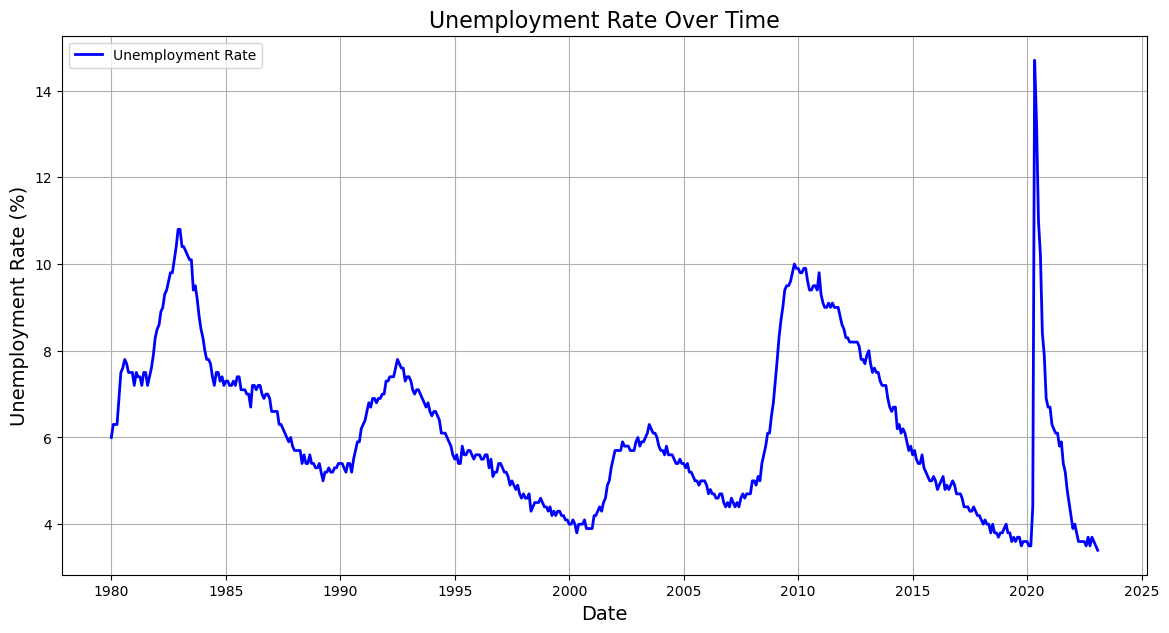

In [7]:
# Plotting the unemployment rate 
plt.figure(figsize=(14, 7))
plt.plot(df['UNRATE'], label='Unemployment Rate', color='b', linewidth=2)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Unemployment Rate (%)', fontsize=14)
plt.title('Unemployment Rate Over Time', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Performing Augmented Dickey-Fuller test to check stationarity
result = adfuller(df['UNRATE'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# If the series is not stationary, difference the data
if result[1] > 0.05:
    df['UNRATE_diff'] = df['UNRATE'].diff().dropna()
    result_diff = adfuller(df['UNRATE_diff'].dropna())
    print('ADF Statistic (after differencing):', result_diff[0])
    print('p-value (after differencing):', result_diff[1])
else:
    result_diff = df['UNRATE']

ADF Statistic: -2.9233573357191083
p-value: 0.04269849852196447


In [9]:
# Splitting the dataset into training and testing sets
train_size = int(len(result_diff) * 0.8)
train, test = result_diff[:train_size], result_diff[train_size:]

# Defining the parameter grid with d = 0 since the series is stationary
p_values = range(0, 5)
q_values = range(0, 5)
d_value = 0  
parameter_combinations = list(product(p_values, [d_value], q_values))

# Initializing variables to track the best parameters and lowest MSE
best_order = None
lowest_mse = float("inf")

# Performing grid search
for order in parameter_combinations:
    try:
        model = ARIMA(train, order=order)
        model_fit = model.fit()
        predictions = model_fit.forecast(steps=len(test))
        mse = mean_squared_error(test, predictions)
        if mse < lowest_mse:
            lowest_mse = mse
            best_order = order
        print(f"ARIMA{order} - MSE: {mse}")
    except Exception as e:
        print(f"ARIMA{order} - Failed with error: {e}")
        continue

print(f'\nBest ARIMA order: {best_order} with MSE: {lowest_mse}')

ARIMA(0, 0, 0) - MSE: 5.568391936585201
ARIMA(0, 0, 1) - MSE: 5.563901947852724
ARIMA(0, 0, 2) - MSE: 5.57471177619178
ARIMA(0, 0, 3) - MSE: 5.562125986412743
ARIMA(0, 0, 4) - MSE: 5.577872360558313
ARIMA(1, 0, 0) - MSE: 5.219763113140757
ARIMA(1, 0, 1) - MSE: 5.1907674089676465
ARIMA(1, 0, 2) - MSE: 5.070155397201465
ARIMA(1, 0, 3) - MSE: 4.994516222540795
ARIMA(1, 0, 4) - MSE: 5.014527190202478
ARIMA(2, 0, 0) - MSE: 5.196463843644192
ARIMA(2, 0, 1) - MSE: 5.169461356706098
ARIMA(2, 0, 2) - MSE: 4.298367589142733
ARIMA(2, 0, 3) - MSE: 4.6594505935897095
ARIMA(2, 0, 4) - MSE: 3.9500295737956703
ARIMA(3, 0, 0) - MSE: 5.021867738132138
ARIMA(3, 0, 1) - MSE: 4.543659755190187
ARIMA(3, 0, 2) - MSE: 5.135845649849129
ARIMA(3, 0, 3) - MSE: 4.305330657065498
ARIMA(3, 0, 4) - MSE: 4.073288097627701
ARIMA(4, 0, 0) - MSE: 4.856736323315407
ARIMA(4, 0, 1) - MSE: 4.615721697904071
ARIMA(4, 0, 2) - MSE: 4.578203306339329
ARIMA(4, 0, 3) - MSE: 4.706333415951243
ARIMA(4, 0, 4) - MSE: 4.35155686767620

Mean Squared Error (MSE): 3.9500295737956703
Mean Absolute Error (MAE): 1.4905323436292948
Mean Absolute Percentage Error (MAPE): 0.32771636418742267


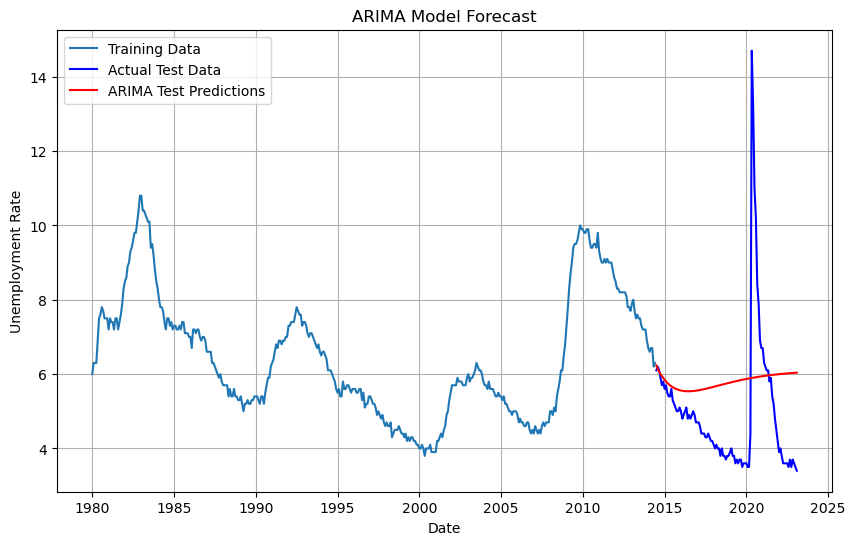

ARIMA forecast results saved to arima_forecast_results.csv


In [10]:
# Fitting the ARIMA model 
model = ARIMA(train, order=best_order)
model_fit = model.fit()

# Forecasting values
forecast = model_fit.forecast(steps=len(test))

# Converting the forecast to a pandas Series for easier comparison
forecast_index = test.index
forecast_series = pd.Series(forecast, index=forecast_index)

# Calculating performance metrics
mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)
mape = mean_absolute_percentage_error(test, forecast)

print('Mean Squared Error (MSE):', mse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Plotting the forecasted values and the actual values
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Test Data', color='blue')
plt.plot(forecast_series, label='ARIMA Test Predictions', color='red')
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.grid(True)
plt.show()

# Saving the results to a CSV file
results_df = pd.DataFrame({
    'Date': forecast_index,
    'Actual': test,
    'Forecasted': forecast_series
})

results_df.to_csv('arima_forecast_results.csv', index=False)
print('ARIMA forecast results saved to arima_forecast_results.csv')

Correlation Matrix:
                  UNRATE       GDP  Change %  InflationRate  UNRATE_LAG_6  \
UNRATE         1.000000 -0.308839  0.105850      -0.048684      0.792948   
GDP           -0.308839  1.000000 -0.014191      -0.113597     -0.279983   
Change %       0.105850 -0.014191  1.000000      -0.057123      0.072207   
InflationRate -0.048684 -0.113597 -0.057123       1.000000      0.047714   
UNRATE_LAG_6   0.792948 -0.279983  0.072207       0.047714      1.000000   
UNRATE_LAG_12  0.640944 -0.242718  0.047685       0.097439      0.785815   

               UNRATE_LAG_12  
UNRATE              0.640944  
GDP                -0.242718  
Change %            0.047685  
InflationRate       0.097439  
UNRATE_LAG_6        0.785815  
UNRATE_LAG_12       1.000000  


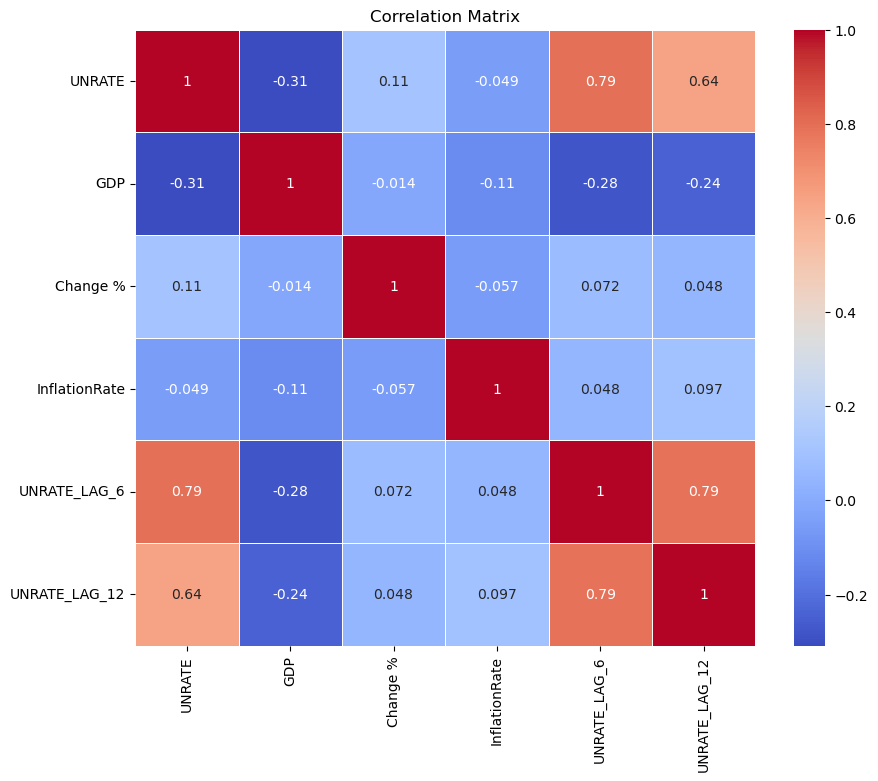

In [11]:
# Loading the dataset
file_path = 'combined_dataset_cleaned.csv'
df = pd.read_csv(file_path)

# Converting the 'DATE' column to datetime and setting as index
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)

# Imputing missing values with mean
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)

# Normalizing the data for model fitting
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_imputed)

# Feature engineering: Adding lag features for 6 months and 12 months
df_imputed['UNRATE_LAG_6'] = df_imputed['UNRATE'].shift(6)
df_imputed['UNRATE_LAG_12'] = df_imputed['UNRATE'].shift(12)

# Dropping rows with NaN values after adding lag features
df_imputed.dropna(inplace=True)

# Re-normalize the data after feature engineering
scaled_data = scaler.fit_transform(df_imputed)

# Prepare the data for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step):
        X.append(data[i:(i+time_step)])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

# Creating the dataset with adjusted indexing
time_step = 10
X, Y = create_dataset(scaled_data, time_step)

# Splitting the data into training and testing datasets (80% training, 20% testing)
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Reshaping the input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Correlation Analysis
correlation_matrix = df_imputed.corr()
print("Correlation Matrix:\n", correlation_matrix)

# Visualizing the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

Reloading Tuner from hyperparam_tuning/lstm_unemployment/tuner0.json
Optimal number of units for first LSTM layer: 32
Optimal number of units for second LSTM layer: 112
Optimal learning rate: 0.01
Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0598 - val_loss: 0.0234
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024 - val_loss: 0.0253
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - val_loss: 0.0169
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.7004e-04 - val_loss: 0.0203
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.4144e-04 - val_loss: 0.0188
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - val_loss: 0.0172
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.9881e-04 - val_loss: 0.0156
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.5046e-04 - val_loss: 0.0130
Epoch 9/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.6644e-04 - val_loss: 0.0126
Epoch 10/10
80/80 ━━━━━━━━━

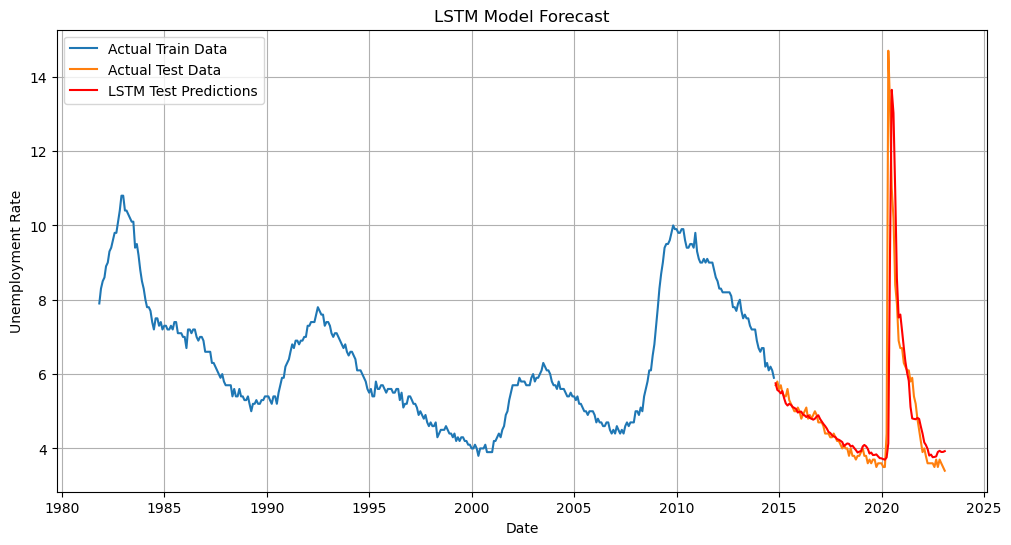

CSV file saved successfully.


In [12]:

# Defining the LSTM model for hyperparameter tuning
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units1', min_value=32, max_value=128, step=16),
                   return_sequences=True, input_shape=(time_step, X_train.shape[2])))
    model.add(LSTM(units=hp.Int('units2', min_value=32, max_value=128, step=16),
                   return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='mean_squared_error')
    return model

# Initializing the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='hyperparam_tuning',
    project_name='lstm_unemployment')

# Performing the hyperparameter search
tuner.search(X_train, Y_train, epochs=10, batch_size=5, validation_data=(X_test, Y_test))

# Getting the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Printing the optimal hyperparameters
print(f"Optimal number of units for first LSTM layer: {best_hps.get('units1')}")
print(f"Optimal number of units for second LSTM layer: {best_hps.get('units2')}")
print(f"Optimal learning rate: {best_hps.get('learning_rate')}")

# Building the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, Y_train, epochs=10, batch_size=5, validation_data=(X_test, Y_test), verbose=1)

# Predicting using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get the actual values
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]
Y_train_actual = scaler.inverse_transform(np.concatenate((Y_train.reshape(-1, 1), np.zeros((Y_train.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]
Y_test_actual = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]

# performance metrics
test_mse = mean_squared_error(Y_test_actual, test_predict)
test_mae = mean_absolute_error(Y_test_actual, test_predict)
test_mape = mean_absolute_percentage_error(Y_test_actual, test_predict)

print('Mean Squared Error:', test_mse)
print('Mean Absolute Error:', test_mae)
print('Mean Absolute Percentage Error:', test_mape)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(df_imputed.index[time_step:train_size+time_step], Y_train_actual, label='Actual Train Data')
plt.plot(df_imputed.index[train_size+time_step:train_size+test_size+time_step], Y_test_actual, label='Actual Test Data')
plt.plot(df_imputed.index[train_size+time_step:train_size+test_size+time_step], test_predict, label='LSTM Test Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate')
plt.title('LSTM Model Forecast')
plt.legend()
plt.grid(True)
plt.show()

# Saving the results to a CSV file
results_lstm_df = pd.DataFrame({
    'Date': df_imputed.index[train_size+time_step:train_size+test_size+time_step],
    'Actual': Y_test_actual.flatten(),
    'Predicted': test_predict.flatten()
})

results_lstm_df.to_csv('actual_vs_predicted_lstm.csv', index=False)

print('CSV file saved successfully.')